Upload Files (data, custom dataset class, and CNN)



In [ ]:
!unzip /content/drive/MyDrive/ColabNotebooks/HuskyTrainingData.zip -d HuskyTrainingData


In [ ]:
!unzip /content/drive/MyDrive/ColabNotebooks/bc_april4.zip -d bc_april4

Streaming output truncated to the last 5000 lines.
  inflating: bc_april4/bc_april4/measurements/measurement_04877.txt  
  inflating: bc_april4/bc_april4/measurements/measurement_04884.txt  
  inflating: bc_april4/bc_april4/measurements/measurement_04906.txt  
  inflating: bc_april4/bc_april4/measurements/measurement_04909.txt  
  inflating: bc_april4/bc_april4/measurements/measurement_04915.txt  
  inflating: bc_april4/bc_april4/measurements/measurement_04922.txt  
  inflating: bc_april4/bc_april4/measurements/measurement_04927.txt  
  inflating: bc_april4/bc_april4/measurements/measurement_04928.txt  
  inflating: bc_april4/bc_april4/measurements/measurement_04937.txt  
  inflating: bc_april4/bc_april4/measurements/measurement_04960.txt  
  inflating: bc_april4/bc_april4/measurements/measurement_04966.txt  
  inflating: bc_april4/bc_april4/measurements/measurement_04970.txt  
  inflating: bc_april4/bc_april4/measurements/measurement_04991.txt  
  inflating: bc_april4/bc_april4/measur

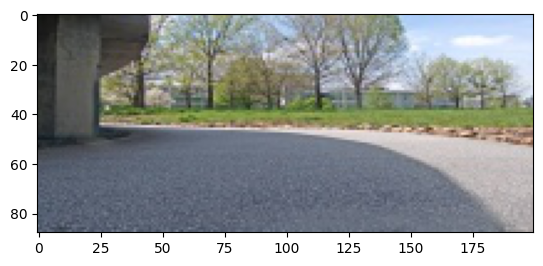

dict_keys(['image', 'measurements'])


In [ ]:
import os
import json
import glob
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#img_path = "./HuskyTrainingData/HuskyTrainingData/2023-02-08-14-51-49/front_images/"
#measurement_path = "./HuskyTrainingData/HuskyTrainingData/2023-02-08-14-51-49/measurements/"

img_path = "./bc_april4/bc_april4/front_images/"
measurement_path = "./bc_april4/bc_april4/measurements/"

img = glob.glob(img_path + "*.jpg")
img.sort()
measure = glob.glob(measurement_path + "*.txt")
measure.sort()

img_names = []
linear = []
angular = []
measurements = []

img_0 = mpimg.imread(img[0])
plt.imshow(img_0)
plt.show()

for filename in img:
      img_names.append(filename)

for filename in measure:
      my_file = open(filename)
      json_data = my_file.read()
      try:
          json_objects = json_data.split("}{")
          first_obj = json.loads(json_objects[0] + "}")
          linear.append(first_obj["linear"])
          angular.append(first_obj["angular"])
      except:
          obj = json.loads(json_data)
          measurements.append(obj)
          linear.append(obj["linear"])
          angular.append(obj["angular"])

data = {
    "image": img_names,
    "measurements": measurements
}

print(data.keys())

dataframe = pd.DataFrame(data)

In [ ]:
""" Custom PyTorch Dataset Class """

import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision.io import read_image


class HuskyDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        image_path = self.dataframe.iloc[index]['image']
        measurements = self.dataframe.iloc[index]['measurements']
        
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)
        
        linear = torch.tensor([measurements['linear']['x'], measurements['linear']['y'], measurements['linear']['z']])
        angular = torch.tensor([measurements['angular']['x'], measurements['angular']['y'], measurements['angular']['z']])
        measurements_tensor = torch.cat([linear, angular])
        
        return image, measurements_tensor

Passing dataframe into custom dataset. Input should be 3 x 200 x 88 tensor

In [ ]:
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((200, 88)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = HuskyDataset(dataframe, transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
""" CNN for Husky Robot """

from torch import nn


class Network(nn.Module):
    """ Convolutional neural network base class """

    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 16, kernel_size=3, stride=3)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(8, 4, kernel_size=3, stride=3)
        self.conv5 = nn.Conv2d(4, 2, kernel_size=1, stride=2)
        self.conv6 = nn.Conv2d(2, 2, kernel_size=1, stride=1)
        self.fc1 = nn.Linear(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(2, 6)

    def forward(self, x):
        """ Feed-Forward: Pass data into nn and perform calc """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = x.squeeze()

        return x

[1] loss: 0.189757
[2] loss: 0.065318
[3] loss: 0.038899
[4] loss: 0.026402
[5] loss: 0.018152
[6] loss: 0.013058
[7] loss: 0.009658
[8] loss: 0.007108
[9] loss: 0.005439
[10] loss: 0.004201
[11] loss: 0.003378
[12] loss: 0.002693
[13] loss: 0.002207
[14] loss: 0.001858
[15] loss: 0.001564
[16] loss: 0.001367
[17] loss: 0.001198
[18] loss: 0.001065
[19] loss: 0.000968
[20] loss: 0.000877
[21] loss: 0.000807
[22] loss: 0.000755
[23] loss: 0.000711
[24] loss: 0.000673
[25] loss: 0.000639
[26] loss: 0.000611
[27] loss: 0.000587
[28] loss: 0.000566
[29] loss: 0.000550
[30] loss: 0.000533
[31] loss: 0.000519
[32] loss: 0.000508
[33] loss: 0.000495
[34] loss: 0.000487
[35] loss: 0.000477
[36] loss: 0.000471
[37] loss: 0.000461
[38] loss: 0.000455
[39] loss: 0.000451
[40] loss: 0.000446
[41] loss: 0.000442
[42] loss: 0.000437
[43] loss: 0.000432
[44] loss: 0.000429
[45] loss: 0.000426
[46] loss: 0.000423
[47] loss: 0.000422
[48] loss: 0.000416
[49] loss: 0.000414
[50] loss: 0.000413
[51] loss

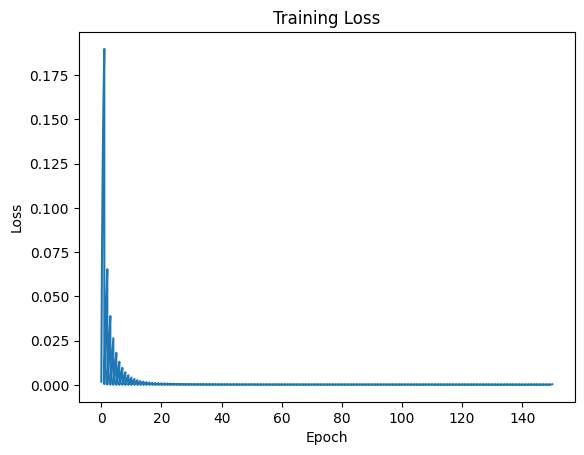

Finished Training


In [ ]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Network().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 150

train_loss = []
train_epoch = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, batch in enumerate(data_loader):
        inputs, labels = batch

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss.append(running_loss / len(data_loader))
        train_epoch.append(epoch + i / len(data_loader))
    print('[%d] loss: %f' % (epoch + 1, running_loss / len(data_loader)))

# Plot the training loss
plt.plot(train_epoch, train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

print('Finished Training')

model_path = "model.pt"
torch.save(model.state_dict(), model_path)